# Entropy of IR fields leading up to MCS initiation
For evolutionary theory paper 

In [2]:
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob 

In [3]:
glob('/Users/bmapes/Downloads/AMZ_23Z*.nc')

['/Users/bmapes/Downloads/AMZ_23Z_2020-11-13_12hleadup.nc',
 '/Users/bmapes/Downloads/AMZ_23Z_2020-05-29_12hleadup.nc',
 '/Users/bmapes/Downloads/AMZ_23Z_2020-05-18_12hleadup.nc',
 '/Users/bmapes/Downloads/AMZ_23Z_2020-10-10_12hleadup.nc']

In [5]:
ds = xr.open_dataset( '/Users/bmapes/Downloads/AMZ_23Z_2020-11-13_12hleadup.nc' ) #, combine='nested', concat_dim='case') 
ds

<xarray.Dataset>
Dimensions:    (lat: 572, lon: 571, time1: 5)
Coordinates:
  * lat        (lat) float32 -36.05 -35.98 -35.91 -35.84 ... 3.71 3.78 3.85 3.92
  * lon        (lon) float32 -72.2 -72.13 -72.06 -71.99 ... -32.44 -32.37 -32.3
  * time1      (time1) datetime64[ns] 2020-11-13T12:00:00 ... 2020-11-14
    time1_run  (time1) datetime64[ns] ...
Data variables:
    irwin_cdr  (time1, lat, lon) float32 ...

In [6]:
# file_dataset.where((file_dataset.time.dt.hour%4 == 1) & (file_dataset.time.dt.minute <= 20), drop=True)

ds.time1.dt.hour

<xarray.DataArray 'hour' (time1: 5)>
array([12, 15, 18, 21,  0])
Coordinates:
  * time1      (time1) datetime64[ns] 2020-11-13T12:00:00 ... 2020-11-14
    time1_run  (time1) datetime64[ns] ...

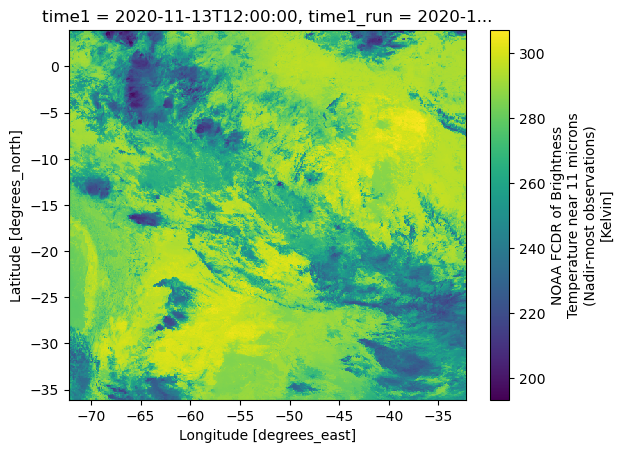

In [7]:
ds.isel(time1=0).irwin_cdr.plot()

In [267]:
# oopen_mfdataset Requires dask for some reason, must install in environment 
# mfds = xr.open_mfdataset( glob('/Users/bmapes/Downloads/AMZ_23Z_2020-11*.nc') ) #, combine='nested', concat_dim='case') 
# Opening several files, it seems to concatenate time even when using concat_dim='case'
# mfds
# Oh this doesnt make sense because the data are MCS centered not fixed lat-lon region

# For each datafile and its IR512 inner array, 
### loop over coarsenings and construct quintile exceedance prob
#### sum those up, by coarsening scale 
using perhaps inelegant exec(string) approach to create each scale's result in an array named by blocksize [1,2,4,8,16,...

In [9]:
fnames = glob('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/Amazon_23Z_MCSinitiations/*')
location = 'AMAZ'
len(fnames)

242

In [11]:
fnames = glob('/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ*/*')
location = 'SPCZ' 
len(fnames)

142

In [18]:
ds = xr.open_dataset(fnames[0]) #, combine='nested', concat_dim='case') 
ds

<xarray.Dataset>
Dimensions:    (lat: 571, lon: 572, time1: 4)
Coordinates:
  * lat        (lat) float32 -31.22 -31.15 -31.08 -31.01 ... 8.47 8.54 8.61 8.68
  * lon        (lon) float32 -179.5 -179.4 -179.4 ... -139.7 -139.6 -139.5
  * time1      (time1) datetime64[ns] 2016-09-02 ... 2016-09-02T09:00:00
    time1_run  (time1) datetime64[ns] ...
Data variables:
    irwin_cdr  (time1, lat, lon) float32 ...

In [19]:
# Loop over coarsening scales 1,2,4,8,..., creating array names for result 

coarsens = 2**np.linspace(0,8,9)
NT,NLAT,NLON = ds.irwin_cdr.shape

for it in range(NT):
  for scale in coarsens: 
    blocksize = int(scale)
    make_arrays = location+'_active'+str(blocksize)+'_time'+str(it)+' = 0'
    #print(make_arrays) 
    exec(make_arrays)

In [20]:
# Now loop over all filenames and do the summing for all the filenames! 
q1s = []  # first quintile and 5th at each time in each file
q5s = []  # first quintile and 5th at each time in each file

for fname in fnames: 
    print(fname) 
    ds = xr.open_dataset(fname) 
    # Extract central 512x512 data array, still in xarray so we can use coarsen()
    IR512 = ds.irwin_cdr.isel(lat = slice(NLAT//2-256,NLAT//2+256), lon = slice(NLON//2-256,NLON//2+256)) 

    # Drop down to numpy level, discarding lat and lon so we can composite
    for it in range(NT):
        sq = IR512[it,:,:]
        quint1 = np.sort( np.ravel( sq.values) )[sq.size//5]     # 1/5
        quint5 = np.sort( np.ravel( sq.values) )[4*sq.size//5]   # 4/5 
        q1s.append(quint1)
        q5s.append(quint5)
        
    # active array: exactly 20% coldest pixels are 1 all others 0, at full pixel resolution
        active = (sq < quint1) 
        
    # loop over coarsening blocks, sampling result back onto 512x512
        for scale in coarsens: 
            blocksize = int(scale)
            cactive = active.coarsen(lat=blocksize, lon=blocksize).mean().\
                interp_like(active, method='nearest', kwargs={"fill_value": "extrapolate"})
# Update the sums, in the form of a string to execute, making array AMAZ_activeB_time[0-4]
            nameit = location+'_active'+str(blocksize)+'_time'+str(it)+' += cactive.values'
            exec(nameit); #print(nameit) 


/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2016-09-02_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2015-01-26_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2016-05-19_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2014-04-17_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2004-01-23_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2006-09-02_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2001-04-09_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2015-02-28_12hleadup.nc
/Users/bmapes/Box/EvolutionaryConvection/Gridsat_images/SPCZ_09Z_MCSinitiations/SPCZ_09Z_2006-02

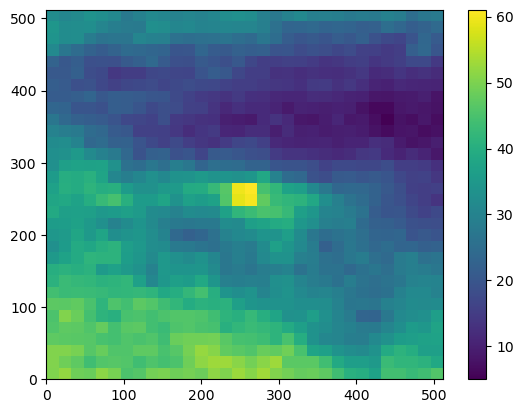

In [29]:
# at time 5 it should all be 1 in the center, right? 

plt.pcolormesh(SPCZ_active16_time3); plt.colorbar()

In [21]:
len(fnames)

142

In [30]:
# Normalize by len(fnames) and then 
# Dump a pickle of each array to the specified file. 
# The array can be read back with pickle.load or numpy.load.
# Example: AMAZ_active1_time0.dump('file.dump')

for it in range(NT):
  for scale in coarsens: 
    blocksize = int(scale)
    namestring = location+'_active'+str(blocksize)+'_time'+str(it)
    normalize = namestring+' = '+namestring+'/len(fnames)' 
    exec(normalize); print(normalize)
    do_dump = namestring+".dump('Gridsat_freq_files/"+namestring+".dump')"
    exec(do_dump); print(do_dump)


SPCZ_active1_time0 = SPCZ_active1_time0/len(fnames)
SPCZ_active1_time0.dump('Gridsat_freq_files/SPCZ_active1_time0.dump')
SPCZ_active2_time0 = SPCZ_active2_time0/len(fnames)
SPCZ_active2_time0.dump('Gridsat_freq_files/SPCZ_active2_time0.dump')
SPCZ_active4_time0 = SPCZ_active4_time0/len(fnames)
SPCZ_active4_time0.dump('Gridsat_freq_files/SPCZ_active4_time0.dump')
SPCZ_active8_time0 = SPCZ_active8_time0/len(fnames)
SPCZ_active8_time0.dump('Gridsat_freq_files/SPCZ_active8_time0.dump')
SPCZ_active16_time0 = SPCZ_active16_time0/len(fnames)
SPCZ_active16_time0.dump('Gridsat_freq_files/SPCZ_active16_time0.dump')
SPCZ_active32_time0 = SPCZ_active32_time0/len(fnames)
SPCZ_active32_time0.dump('Gridsat_freq_files/SPCZ_active32_time0.dump')
SPCZ_active64_time0 = SPCZ_active64_time0/len(fnames)
SPCZ_active64_time0.dump('Gridsat_freq_files/SPCZ_active64_time0.dump')
SPCZ_active128_time0 = SPCZ_active128_time0/len(fnames)
SPCZ_active128_time0.dump('Gridsat_freq_files/SPCZ_active128_time0.dump')
SPCZ

# Make frequency versions of these arrays 
## which have 20% coverage by construction (quintile exceedance) 
### Assess non-uniformity of resulting as entropy difference from max

In [161]:
# Bin the exceedance array into a histogram for entropy computation 

coldfreq = (sq16 < quint1) # later will want to sum over cases 

hist = coldfreq.to_dataset().groupby_bins('irwin_cdr', bins=np.linspace(-0.005,1,120) ).mean()
hist.irwin_cdr

<xarray.DataArray 'irwin_cdr' (irwin_cdr_bins: 119)>
array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan,  1.])
Coordinates:
  * irwin_cdr_bins  (irwin_cdr_bins) object (-0.005, 0.00345] ... (0.992, 1.0]
    time1           datetime64[ns] 2020-05-18T12:00:00
    time1_run       datetime64[ns] 2020-05-18T12:00:00

In [162]:
# in comes a histogram, out comes an entropy 
def entropy(histogram): 
    histo = histogram.fillna(1E-99) + 1E-99 # replace both 0 and nan with 1 or 2 e-99
    p = histo/np.sum(histo) 
    H = -np.sum( p* np.log2(p) ) 
    return H.values

In [163]:
histo = hist.irwin_cdr.fillna(1E-99) + 1e-99
#histo
p = histo/np.sum(histo) 
#p
#p*np.log2(p)
np.sum( p* np.log2(p) ).values

array(-7.70506571e-95)

In [168]:
entropy(hist.irwin_cdr)

array(7.70506571e-95)

In [171]:
entropy(hist.irwin_cdr + 100) # nearly uniform distribution, one value is 101 

array(0.99998215)